<a href="https://colab.research.google.com/github/tperfetti/ML/blob/main/Module_9_Perfetti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ingest (1.0)

In [ ]:
from matplotlib import pyplot as plt
import math, os, re, time, random, string
import numpy as np, pandas as pd, seaborn as sns

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('ggplot')   #for optimum aesthetics 
import seaborn as sns

#natural language processing
from collections import defaultdict
#import wordcloud

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data = pd.read_csv('sample_submission.csv')

## EDA (2.0)

In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
#save ID
test_id = test['id']

#drop from train and test
columns = {'id', 'location'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

#fill missing with unknown
train['keyword'] = train['keyword'].fillna('unknown')
test['keyword'] = test['keyword'].fillna('unknown')

#add keyword to tweets
train['text'] = train['text'] + ' ' + train['keyword']
test['text'] = test['text'] + ' ' + test['keyword']

#drop fkeyword rom train and test
columns = {'keyword'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

#combine so we work smarter, not harder
total = train.append(test)

In [ ]:
print('There are', len(train), 'rows in the train set')
print('There are', len(test), 'rows in the test set')

There are 7613 rows in the train set
There are 3263 rows in the test set


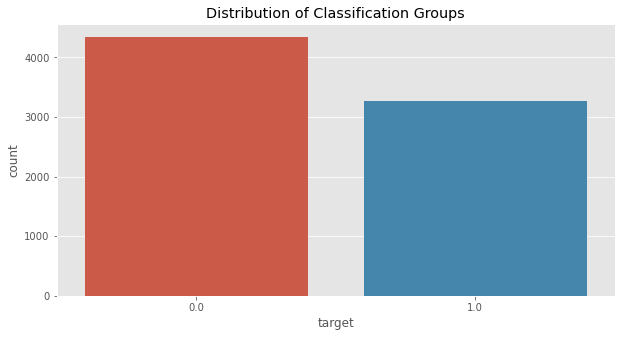

In [ ]:
#set figure size
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
graph1 = sns.countplot(x = 'target', data = total)

#give title and plot
plt.title('Distribution of Classification Groups')
plt.show(graph1)

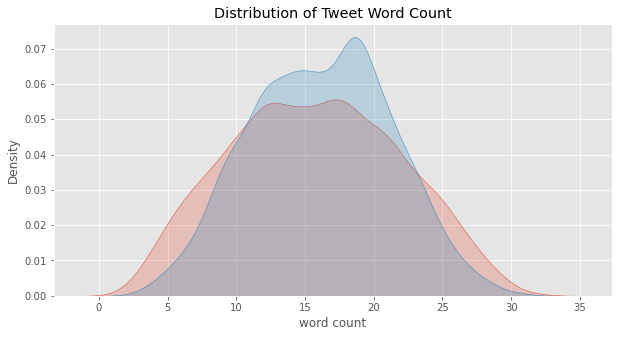

In [ ]:
#create column for the number of words in tweet
total['word count'] = total['text'].apply(lambda x: len(x.split()))

#split so we can use updated train set with new feature
train = total[:len(train)]

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train['word count'][train['target'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(train['word count'][train['target'] == 1], shade = True, label = 'Disaster tweet')

#set title and plot
plt.title('Distribution of Tweet Word Count')
plt.show()

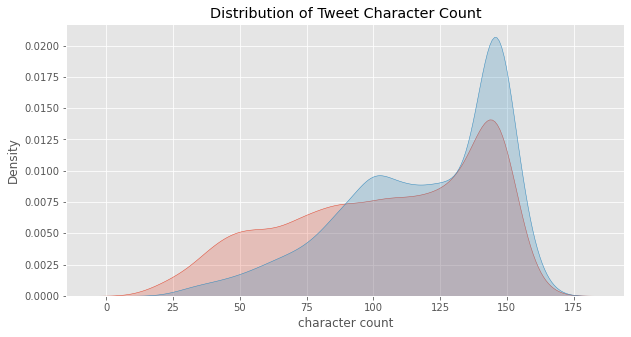

In [ ]:
#create column for the number of characters in a tweet
total['character count'] = total['text'].apply(lambda x: len(x))

#split so we can use updated train set with new feature
train = total[:len(train)]

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train['character count'][train['target'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(train['character count'][train['target'] == 1], shade = True, label = 'Disaster tweet')

#set title and plot
plt.title('Distribution of Tweet Character Count')
plt.show()

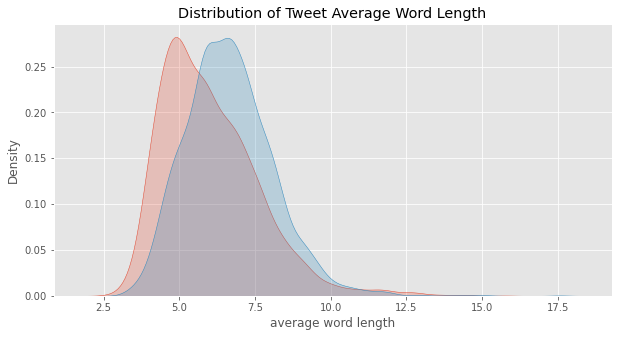

In [ ]:
#define function to find average word length 
def average_word_length(x):
    x = x.split()
    return np.mean([len(i) for i in x])

#broadcast to text column
total['average word length'] = total['text'].apply(average_word_length)

#split so we can use updated train set with new feature
train = total[:len(train)]

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train['average word length'][train['target'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(train['average word length'][train['target'] == 1], shade = True, label = 'Disaster tweet')

#set title
plt.title('Distribution of Tweet Average Word Length')

#splot graphs
plt.show()

In [ ]:
#remove punctuation
def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

#remove stopwords
def remove_stopwords(x):
    return ' '.join([i for i in x.split() if i not in wordcloud.STOPWORDS])

#remove words less than 4 
def remove_less_than(x):
    return ' '.join([i for i in x.split() if len(i) > 3])

#remove words with non-alphabet characters
def remove_non_alphabet(x):
    return ' '.join([i for i in x.split() if i.isalpha()])

def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

In [ ]:
#check strip_all_entities functionality
strip_all_entities('@shawn Titanic #tragedy could have been prevented Economic \
                   Times: Telegraph.co.ukTitanic tragedy could have been preve... http://bet.ly/tuN2wx')

'Titanic tragedy could have been prevented Economic Times Telegraph co ukTitanic tragedy could have been preve'

In [ ]:
#install autocorrect
!pip install autocorrect
from autocorrect import Speller 

#create function to spell check strings
def spell_check(x):
    spell = Speller(lang='en')
    return " ".join([spell(i) for i in x.split()])

#showcase spellcheck 
mispelled = 'Pleaze spelcheck this sentince'
spell_check(mispelled)

     |████████████████████████████████| 622 kB 1.8 MB/s eta 0:00:01
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622382 sha256=57d2f0f7b123f87a9d26d845cc2325edb07d3cfd01c724cb75a6433ea871a06c
  Stored in directory: /Users/torrenceperfetti/Library/Caches/pip/wheels/ab/0f/23/3c010c3fd877b962146e7765f9e9b08026cac8b035094c5750
Successfully built autocorrect


'Please spelcheck this sentence'

In [ ]:
PROCESS_TWEETS = False
if PROCESS_TWEETS:
    #apply all of above functions
    total['text'] = total['text'].apply(lambda x: x.lower())
    total['text'] = total['text'].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x, flags = re.MULTILINE))
    total['text'] = total['text'].apply(remove_punctuation)
    total['text'] = total['text'].apply(remove_stopwords)
    total['text'] = total['text'].apply(remove_less_than)
    total['text'] = total['text'].apply(remove_non_alphabet)
    total['text'] = total['text'].apply(spell_check)

In [ ]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expand_contractions(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)

expand_contractions("can't stop won't stop")

'cannot stop will not stop'

In [ ]:
#apply to whole text column
total['text'] = total['text'].apply(expand_contractions)

In [ ]:
 def clean(tweet):

    #correct some acronyms while we are at it
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)      
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet) 
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)  
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)  
    tweet = re.sub(r"amirite", "am I right", tweet)
    
    #and some typos/abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    #hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)

    return tweet

total['text'] = total['text'].apply(clean)

In [ ]:
tweets = [tweet for tweet in total['text']]

#split data to update changes
train = total[:len(train)]
test = total[len(train):]

## Modeling (3.0)

In [ ]:
from keras.preprocessing.text import Tokenizer

#find way to tokenize punctuation
to_exclude = '*+-/()%\n[\\]{|}^_`~\t'
to_tokenize = '!"#$&?:;<=>@'
tokenizer = Tokenizer(filters = to_exclude)
text = 'Why are you so f%#@ing angry all the time?!'
text = re.sub(r'(['+to_tokenize+'])', r' \1 ', text)
tokenizer.fit_on_texts([text])

#view new text
print(tokenizer.word_index)

{'why': 1, 'are': 2, 'you': 3, 'so': 4, 'f': 5, '#': 6, '@': 7, 'ing': 8, 'angry': 9, 'all': 10, 'the': 11, 'time': 12, '?': 13, '!': 14}


In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras import Input

#define tokenizer options
tokenizer = Tokenizer()     
#tokenizer = Tokenizer(oov_token = '<OOV>')           #if you wanted to tokenized OOV words
#tokenizer = Tokenizer(filters = to_exclude)          #if you wanted to include punctuation
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences)
labels = train['target']
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

nlp_train = data[:len(train)]
labels = labels
nlp_test = data[len(train):]

MAX_SEQUENCE_LENGTH = data.shape[1]

Found 29279 unique tokens.
Shape of data tensor: (10876, 40)
Shape of label tensor: (7613,)


In [ ]:
EMBEDDING_DIM = 200   #defined by size of GloVe word vector dimensions

In [ ]:
#initialize embedding matrix with zeros
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

#add glove word encodings to our library
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print("Our embedded matrix is of dimension", embedding_matrix.shape)

100%|█████████████████████████████████| 29279/29279 [00:00<00:00, 983707.23it/s]

Our embedded matrix is of dimension (29280, 200)


In [ ]:
#import neural network basic
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, Concatenate, LeakyReLU, GRU
from keras import Input, Model, regularizers
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix],
                     input_length = MAX_SEQUENCE_LENGTH, trainable = False)  

#we do not want embedding layer to train since it has been pretrained

ImportError: cannot import name 'Adam' from 'keras.optimizers' (/Users/torrenceperfetti/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers.py)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def scale(df, scaler):
    return scaler.fit_transform(df.iloc[:, 2:])

#and scal
meta_train = scale(train, StandardScaler())
meta_test = scale(test, StandardScaler())

In [ ]:
#function to create lstm model
def create_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate, bidirectional = False):
    #define activation
    activation = LeakyReLU(alpha = 0.01)
    
    #define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    #add LSTM layer
    if bidirectional:
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal')))(emb)
    else:
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal'))(emb)        
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [ ]:
#define conveient training function to visualize learning curves
def plot_learning_curves(history): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])

    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper left')

    fig.suptitle("Model Accuracy", fontsize=14)

    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    return plt.show()

In [ ]:
#create our first model
lstm = create_lstm(spatial_dropout = .2, dropout = .2, recurrent_dropout = .2,
                     learning_rate = 3e-4, bidirectional = True)
lstm.summary()

NameError: name 'embedding' is not defined

In [ ]:
#fit model
history1 = lstm.fit([nlp_train, meta_train], labels, validation_split = .2,
                       epochs = 5, batch_size = 21, verbose = 1)

NameError: name 'lstm' is not defined

In [ ]:
#view model 1 learning curves
plot_learning_curves(history1)

NameError: name 'history1' is not defined

## Conclusion (4.0)

As described in the Module 9 Assignment 1 Requirements section on Canvas, please reference how I addressed each stated requirement/question below:
- <b>Conduct your analysis using a cross-validation design</b>This was addressed in section 3.0.
- <b>Conduct / refine EDA</b>This was addressed in section 2.0.
- <b>Build at least three RNN models based on hyperparameter tuning</b> N/A.
- <b>Discuss your model’s performance</b> I was unable to successfully build a RNN model.